In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [18]:
class pipeline():
    def __init__(self) -> None:
        self.imagedes = {
            'image_name': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
            'target' : tf.io.FixedLenFeature([], tf.string)
        }
        self.imgsize= [256,256]
        self.imght = 256
        self.imgwd = 256

    def image_ext1(self, image):
        return image
    
    def image_ext(self, image):
        image = tf.image.decode_jpeg(image, channels=3)
        image = (tf.cast(image, tf.float32)/127.5) -1
        image = tf.reshape(image,[*self.imgsize, 3])
        return image

    def augment(self, image):
        image = tf.image.resize(image, [286, 286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = tf.image.random_crop(image, size=[self.imght, self.imgwd, 3])
        image = tf.image.random_flip_left_right(image)
        return image

    def image_parsing(self, ex):
        parsing_ex = tf.io.parse_single_example(ex, self.imagedes)
        image = self.image_ext(parsing_ex["image"])
        image = self.augment(image)
        return image
  
    def pathdef(self, dir_path):
        path_list =[]
        for p in os.listdir(dir_path):
            path_list.append(os.path.join(dir_path, p))
        return path_list

    def load_dataset(self, dir_path):
        ps = self.pathdef(dir_path)
        ds = tf.data.TFRecordDataset(ps)
        ds = ds.map(self.image_parsing, num_parallel_calls = tf.data.AUTOTUNE)
        return ds

    def plotimg(self, ds):
        ex = next(iter(ds))
        plt.imshow(ex[0]*0.5+0.5)
        plt.axis('off')
        plt.show()

In [20]:
mp = "D:/Northwestern/Deep Learning/dataset/gan-getting-started/monet_tfrec"
pp = "D:/Northwestern/Deep Learning/dataset/gan-getting-started/photo_tfrec"

In [21]:
pipe = pipeline()
monetds = pipe.load_dataset(mp).batch(1)

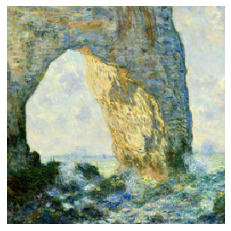

In [22]:
pipe.plotimg(monetds)

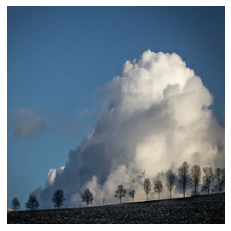

In [23]:
photods = pipe.load_dataset(pp).batch(2)
pipe.plotimg(photods)

In [24]:

class instancenorm(layers.Layer):
    def __init__(self, ep = 1e-5):
        super(instancenorm, self).__init__()
        self.ep = ep
    
    def bb(self, input_shape):
        self.scale = self.add_weight(name = 'scale', shape = input_shape[-1:], initialize = tf.random_normal_initializer(1, 0.02), trainable = True)
        self.of = self.add_weight(name = 'offset', shape = input_shape[-1:], initialize = 'zeros', trainable = True)

    def call(self, x):
        me, var = tf.nn.moments(x, axes= [1,2], keepdims= True)
        inver = tf.math.rsqrt(var + self.ep)
        norm = (x-me)*inver
        return self.scale*norm + self.of
        
        
    

In [57]:
from tensorflow.keras import activations
class cg:
    def __init__(self, output_channels = 3):
        self.celoss = keras.losses.BinaryCrossentropy(from_logits=True)
        self.out_chs = output_channels
        self.LAM = 10
        self.ggen = self.Gen()
        self.fgen = self.Gen()

        self.xdis = self.Dis(target = False)
        self.ydis = self.Dis(target = False)

        self.ggen_opt = keras.optimizers.Adam(2e-4, beta_1 = 0.5)
        self.fgen_opt = keras.optimizers.Adam(2e-4, beta_1 = 0.5)

        self.xdis_opt = keras.optimizers.Adam(2e-4, beta_1 = 0.5)
        self.ydis_opt = keras.optimizers.Adam(2e-4, beta_1 = 0.5)

    def upsampling(self, filters, size, apply_dropout = False):
        initialize = tf.random_normal_initializer(0., 0.02)
        res = tf.keras.Sequential()
        res.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
        kernel_initializer = initialize, use_bias = False))

        if apply_dropout:
            res.add(keras.layers.Dropout(0.5))
        res.add(layers.Activation(activations.relu))
        return res
    
    def downsampling(self, filters, size, apply_normalization = True):
        initialize = tf.random_normal_initializer(0.,0.02)
        res = tf.keras.Sequential()
        res.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
        kernel_initializer = initialize, use_bias = False))

        if apply_normalization:
            res.add(keras.layers.BatchNormalization())
        res.add(layers.Activation(activations.relu))
        return res
    
    def dis_loss(self, real, generate):
        loss_real = self.celoss(tf.ones_like(real), real)
        loss_gen = self.celoss(tf.zeros_like(generate), generate)
        loss_total = loss_real + loss_gen
        return loss_total * 0.5
    
    def gen_loss(self, predict_gen):
        return self.celoss(tf.ones_like(predict_gen), predict_gen)
    
    def loss_cycle(self, image_real, image_cycle):
        loss1 = tf.reduce_mean(tf.abs(image_real-image_cycle))
        return loss1*self.LAM

    def ident_loss(self, image_real, image_same):
        loss1 = tf.reduce_mean(tf.abs(image_real - image_same))
        return loss1*self.LAM*0.5

    def Gen(self):
        dstack=[
          self.downsampling(64,4, apply_normalization=False),
          self.downsampling(128,4),
          self.downsampling(256,4),
          self.downsampling(512,4),
          self.downsampling(512,4),
          self.downsampling(512,4),
          self.downsampling(512,4),
          self.downsampling(512,4),
          ]

        ustack = [
          self.upsampling(512, 4, apply_dropout=True),
          self.upsampling(512, 4, apply_dropout=True),
          self.upsampling(512, 4, apply_dropout=True),
          self.upsampling(512, 4),
          self.upsampling(256, 4),
          self.upsampling(128, 4),
          self.upsampling(64, 4),
          ]

        initialize = tf.random_normal_initializer(0., 0.02)
        lst = layers.Conv2DTranspose(self.out_chs, 4, strides= 2, padding = 'same',
        kernel_initializer = initialize, activation = 'tanh')
        concate = layers.Concatenate()
        inps = layers.Input(shape=[None, None, 3])

        inp = inps
        skips = []
        for d in dstack:
            inp = d(inp)
            skips.append(inp)
        
        skips = reversed(skips[:-1])


        for u, skip in zip(ustack, skips):
            inp = u(inp)
            inp = concate([inp, skip])
        
        inp = lst(inp)

        return keras.Model(inputs = inps, outputs = inp)

    def Dis(self, target =True):
        initialize = tf.random_normal_initializer(0., 0.02)
        #lst = layers.Conv2DTranspose(self.out_chs, 4, strides= 2, padding = 'same',
        #kernel_initializer = initialize, activation_fn = 'tanh')
        #concate = layers.Concatenate()
        inps1 = layers.Input(shape=[None, None, 3], name = 'input_image')

        inp = inps1
        if target:
            tar1 = layers.Input(shape=[None, None, 3], name = 'target_image')
            inp = layers.Concatenate([inps1, tar1])
        
        downb1 = self.downsampling(64, 4, apply_normalization=False)(inp)
        downb2 = self.downsampling(128, 4)(downb1)
        downb3 = self.downsampling(256, 4)(downb2)
        zero_padding1 = layers.ZeroPadding2D()(downb3)
        conv1 = layers.Conv2D(512, 4, strides= 1, kernel_initializer= initialize,
        use_bias = False)(zero_padding1)
        normal1 = layers.BatchNormalization()(conv1)
        leaky_relu = layers.LeakyReLU()(normal1)
        zero_padding2 = layers.ZeroPadding2D()(leaky_relu)
        lst = layers.Conv2D(1, 4, strides= 1, kernel_initializer= initialize)(zero_padding2)

        if target:
            return keras.Model(inputs = [inps1, lst], outputs = lst)
        
        else:
            return keras.Model(inputs = inps1, outputs = lst)

    @tf.function
    def training_step(self, xreal, yreal):
        with tf.GradientTape(persistent=True) as tp:
            unreal_y = self.ggen(yreal, training = True)
            xcycle = self.fgen(unreal_y, training = True)

            unreal_x = self.fgen(yreal, training = True)
            ycycle = self.ggen(unreal_x, training = True)

            same_y = self.ggen(yreal, training = True)
            same_x = self.fgen(xreal, training = True)

            pred_xreal_dis = self.xdis(xreal, training = True)
            pred_xunreal_dis = self.xdis(unreal_x, training = True)

            pred_yreal_dis = self.ydis(yreal, training = True)
            pred_yunreal_dis = self.ydis(unreal_x, training = True)

            cycleloss_tot = self.loss_cycle(xreal, xcycle) + self.loss_cycle(yreal, ycycle)
            ggen_ident_loss = self.ident_loss(yreal, same_y)
            fgen_ident_loss = self.ident_loss(xreal, same_x)

            ggen_loss = self.gen_loss(pred_yunreal_dis)
            fgen_loss = self.gen_loss(pred_xunreal_dis)
            
            total_ggen = ggen_loss + ggen_ident_loss + cycleloss_tot
            total_fgen = fgen_loss + fgen_ident_loss + cycleloss_tot

            xloss_dis = self.dis_loss(pred_xreal_dis, pred_xunreal_dis)
            yloss_dis = self.dis_loss(pred_yreal_dis, pred_yunreal_dis)

            grad_ggen = tp.gradient(total_ggen, self.ggen.trainable_variables)
            grad_fgen = tp.gradient(total_fgen, self.fgen.trainable_variables)

            grad_xdis = tp.gradient(xloss_dis, self.xdis.trainable_variables)
            grad_ydis = tp.gradient(yloss_dis, self.ydis.trainable_variables)

            self.ggen_opt.apply_gradients(zip(grad_ggen, self.ggen.trainable_variables))
            self.fgen_opt.apply_gradients(zip(grad_fgen, self.fgen.trainable_variables))

            self.xdis_opt.apply_gradients(zip(grad_xdis, self.xdis.trainable_variables))
            self.ydis_opt.apply_gradients(zip(grad_ydis, self.ydis.trainable_variables))
        
    def training_image(self, photo, modelgen, fig_size = ((12,12))):
        pred_image = modelgen(photo)
        titles = ["Original Image", "Monet Image"]
        Images = [photo[0], pred_image[0]]
        plt.figure(figsize=fig_size)

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(titles[i])
            plt.imshow(Images[i]*0.5 + 0.5)
            plt.axis('off')
        plt.show()

    def gen_images(self, dataset, modelgen, fig_size = (12, 12), number =5 ):
        plt.figure(figsize=fig_size)
        for imag in dataset.take(number):
            self.training_image(imag, modelgen)
    
    def tra(self, xtrain, ytrain, visited = "g", epochs = 10):
        if(visited.lower() == "g"):
            photo = next(iter(xtrain))
            modelgen = self.ggen
        elif(visited.lower() == "f"):
            photo = next(iter(ytrain))
            modelgen = self.fgen

        print("Before the training process")
        self.training_image(photo, modelgen)
        for e in range(epochs):
            st = time.time()
            for ximg, yimg in tf.data.Dataset.zip((xtrain, ytrain)):
                self.training_step(ximg, yimg)
            clear_output(wait = True)
            self.training_image(photo, modelgen)
            print(f"Epoch time {e + 1} is :{time.time() - st}")


    

In [58]:
model = cg()

In [59]:
ex = next(iter(photods))

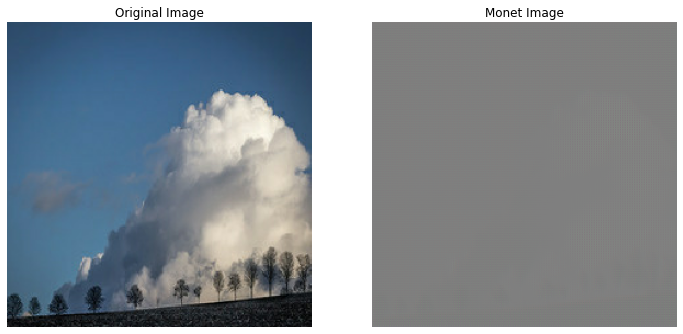

In [60]:
model.training_image(ex, model.ggen)

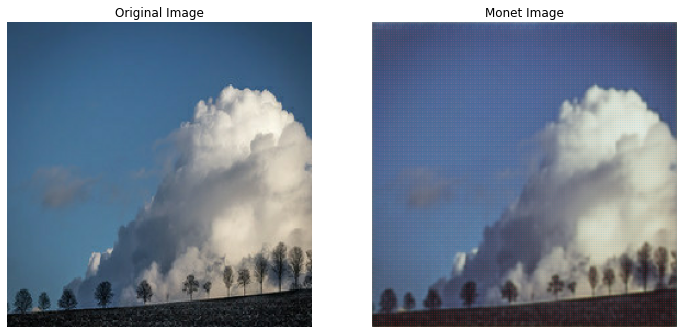

Epoch time 10 is :617.648176908493


In [65]:
model.tra(photods, monetds)

<Figure size 864x864 with 0 Axes>

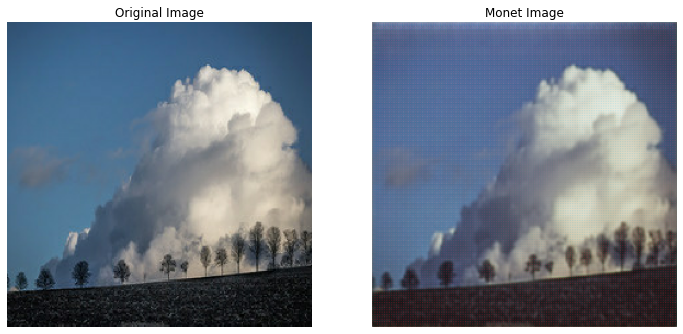

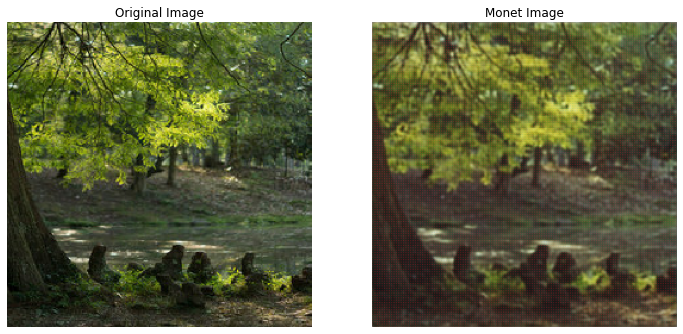

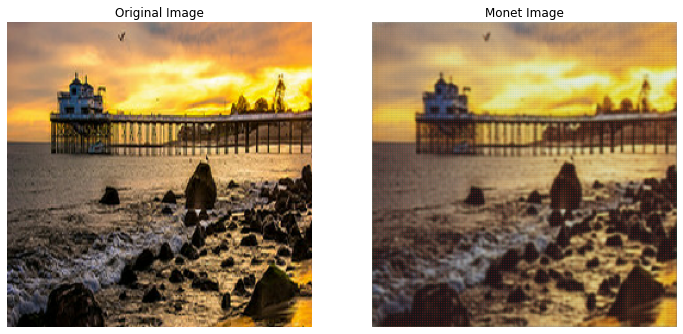

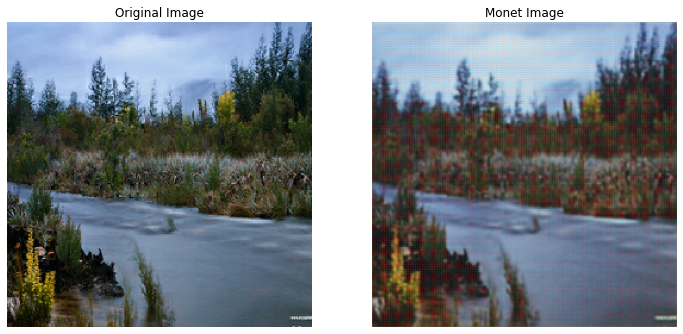

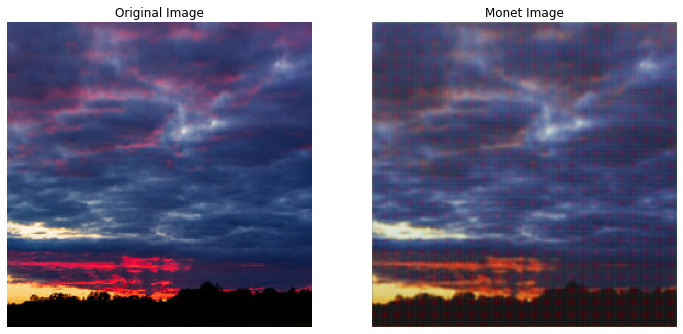

In [66]:
model.gen_images(photods, model.ggen)

<Figure size 864x864 with 0 Axes>

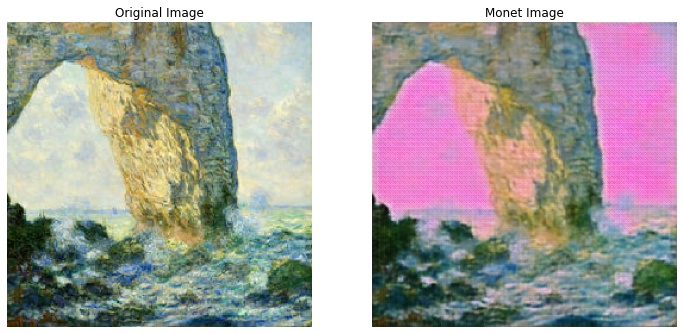

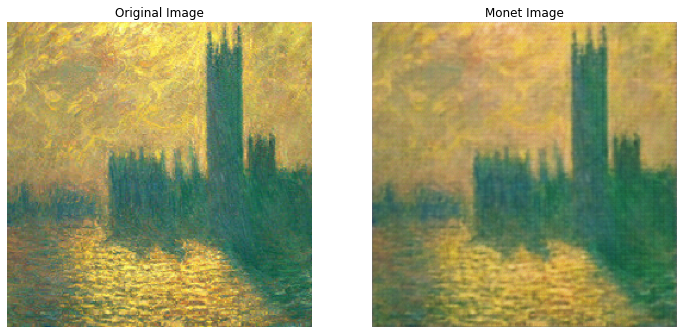

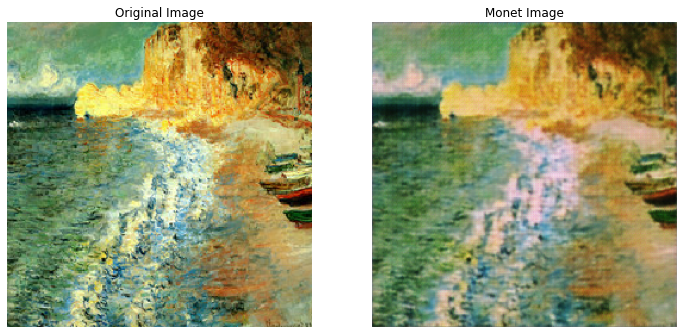

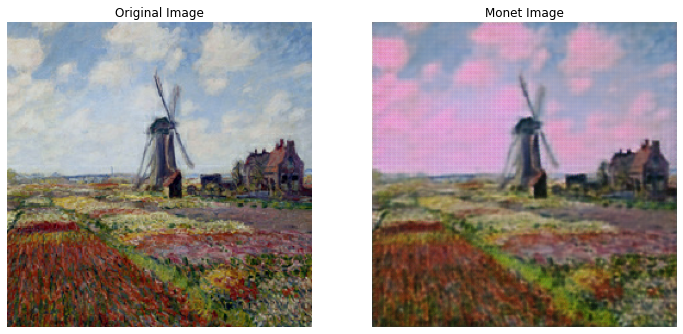

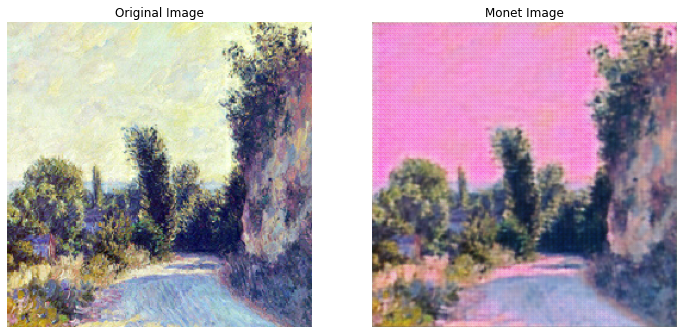

In [67]:
model.gen_images(monetds, model.fgen)